# Analysing the heat vulnerability within the Boton Metropolitan Region

## Introduction

>Extreme heat is considered to be a chronic climate hazard that will influence the Boston’s climate change throughout the 21st century. Average summer temperature is expected to increase from 69 degrees Fahrenheit during 1980-2010 to 76 degrees Fahrenheit by 2050 with more days of extreme heat. The Boston urban area tends to be hotter than its surrounding suburban and rural areas because of the urban heat island effect.

>The purpose of this analysis is to determine the overall vulnerability of ZCTAs within the Boston Metropolitan Region, considering the following factors:
>>- Population below the poverty level
>>- Population over 25 years with less than a High School degree
>>- Age-dependency ratio indicating number of young children and older adults dependent on the working population
>>- Population that is non-White
>>- Mean land surface temperature
>>- Tree canopy cover

>The first four factors indicate socio-economic vulnerability of the ZCTAs and the last two indicate environmental burdens.

## Data Used:

>**Vector Shapefiles(.shp)**
>>- Massachusetts MPO boundaries: *boston-data/RAW_DATA/Vectors/MPO_Boundaries.shp*
>>- Massachusetts ZCTA boundaries: *boston-data/RAW_DATA/Vectors/mass_zcta.shp*

>**American Community Survey(2019) Spreadsheets(.csv)**
>>- Race: *boston-data/RAW_DATA/ACS_Spreadsheets/ACSDT5Y2019.B02001_data_with_overlays.csv*
>>- Age-Dependency Ratio: *boston-data/RAW_DATA/ACS_Spreadsheets/ACSST5Y2019.S0101_data_with_overlays.csv*
>>- Educational Attainment: *boston-data/RAW_DATA/ACS_Spreadsheets/ACSST5Y2019.S1501_data_with_overlays.csv*
>>- Poverty: *boston-data/RAW_DATA/ACS_Spreadsheets/ACSST5Y2019.S1701_data_with_overlays.csv*

>**Raster Images(GeoTiff)**
>>- Land Surface Temperature: *boston-data/RAW_DATA/Rasters/LandSurfaceTemperature/lst_bostonmetro.tif*
>>- Tree Canopy Cover: *boston-data/RAW_DATA/Rasters/TreeCanopyCover/NLCD_2016_Tree_Canopy_Boston.tif*

## Analysis Overview:

>1. Read in all the shapefiles, rasters and spreadsheets.
>2. Set the coordinate reference system for all vectors based on the rasters.
>3. Select the Boston MPO region and clip the ZCTA boundaries within it.
>4. Attribute join the spreadsheets with the ZCTA boundaries using the ZCTA codes. Summarize and map the fields that are use further in the analysis.
>5. Perform zonal statistics using the ZCTA shapefile to extract the mean land surface temperature(LST) and tree canopy cover(TCC) from the rasters.
>6. Create bins for classifying the demographic variables into five categories of vulnerability with 1 indicating leas vulnerability and 5 indicating highest vulnerability.
>7. Normalize the demographic and mean LST and TCC variables using mean and standard deviation. Classify the normalized values into five bins. The five bins numbered 1 to 5 act as the vulnerability scores which is used to calculate a final aggregate vulnerability for every ZCTA.
>8. Percentile rank the aggregate vulnerability and then visualize it. Report the top 80% and bottom 20% ZCTAs.

#### Import Dependencies

In [852]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import folium
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio import features
from rasterstats import zonal_stats
import os
import mapclassify
import contextily as ctx


#### Load the MPO boundaries of Massachusetts and select the Boston Region. Save it as a new variable.

<AxesSubplot:>

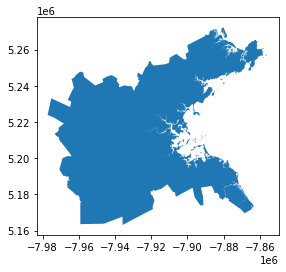

In [746]:
mpo_boundary = gpd.read_file(r'./boston-data/RAW_DATA/Vectors/MPO_Boundaries.shp')
select_mpo = mpo_boundary[mpo_boundary.MPO=='Boston Region']
select_mpo.plot()


#### Load the ZCTA boundaries of Massachusetts and check the first few rows of the attribute table. The 'ZCTA5CE10' column will be used as the primary key for attribute joins at a later stage.

In [747]:
ZCTA = gpd.read_file('./boston-data/RAW_DATA/Vectors/mass_zcta.shp')
ZCTA.head()

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  \
0        25     02536  2502536        B5   G6350          S   71696166   
1        25     02556  2502556        B5   G6350          S   10034104   
2        25     02540  2502540        B5   G6350          S   27746696   
3        25     02646  2502646        B5   G6350          S    7798581   
4        25     01237  2501237        B5   G6350          S  160121626   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   9066635  +41.5969756  -070.5678768         N   
1   1164445  +41.6394454  -070.6245149         N   
2   4550024  +41.5741900  -070.6282848         N   
3    801405  +41.6705961  -070.0714493         N   
4   1140685  +42.5478177  -073.2680327         N   

                                            geometry  
0  POLYGON ((-70.59239 41.56006, -70.59268 41.559...  
1  POLYGON ((-70.62389 41.61673, -70.62633 41.617...  
2  POLYGON ((-70.62389 41.61673, -70.62262 41.616...  
3  POLYGON ((-70.07925 41.67769, -70.07864 41.677...  
4  POLYGON ((-73.23558 42.49333, -73.23587 42.493...

<AxesSubplot:>

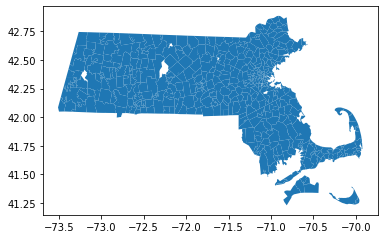

In [748]:
ZCTA.plot()


#### Load four different ACS spreadsheets for the demographic variables that are going to be used for the analysis. The spreadsheets have the file extension '.csv'.
> The four variables are: percent of people below poverty level, age-dependency ratio, population (over 25yrs) with less than a high school degree and percentage of non-Whites. At this stage, the spreadsheets are just being imported and cleaned. Moreover, the columns that are eventually going to be used are the only ones that are being imported.

> The column 'NAME' will eventually be used to perform attribute joins with the ZCTA boundary file. The last five characters of the column are going to be cropped and added to a new column named 'ID_CODE'.

In [749]:
#First demographic variable: percent of people below poverty level
poverty = pd.read_csv('./boston-data/RAW_DATA/ACS_Spreadsheets/ACSST5Y2019.S1701_data_with_overlays.csv', usecols=[0,1,246], skiprows=[1])

In [750]:
poverty.head()

GEO_ID         NAME S1701_C03_001E
0  8600000US01001  ZCTA5 01001            8.5
1  8600000US01002  ZCTA5 01002             26
2  8600000US01003  ZCTA5 01003           80.2
3  8600000US01005  ZCTA5 01005            8.6
4  8600000US01007  ZCTA5 01007            6.1

In [751]:
#check the data type of the columns in the spreadsheet
poverty.dtypes

GEO_ID            object
NAME              object
S1701_C03_001E    object
dtype: object

In [752]:
#remove 'ZCTA5' from the column 'NAME' to add the last five numbers to a new column 'ID_CODE'
poverty['ID_CODE'] = poverty['NAME'].str.replace('ZCTA5 ', '')
poverty.head()

GEO_ID         NAME S1701_C03_001E ID_CODE
0  8600000US01001  ZCTA5 01001            8.5   01001
1  8600000US01002  ZCTA5 01002             26   01002
2  8600000US01003  ZCTA5 01003           80.2   01003
3  8600000US01005  ZCTA5 01005            8.6   01005
4  8600000US01007  ZCTA5 01007            6.1   01007

In [753]:
#convert the data type of the 'ID_CODE' column from string to numberic
poverty['ID_CODE'] = pd.to_numeric(poverty.ID_CODE)
poverty.dtypes

GEO_ID            object
NAME              object
S1701_C03_001E    object
ID_CODE            int64
dtype: object

In [754]:
#Second demographic variable: age-dependency ratio
age_dep_ratio = pd.read_csv('./boston-data/RAW_DATA/ACS_Spreadsheets/ACSST5Y2019.S0101_data_with_overlays.csv', usecols=[0,1,68], skiprows=[1])

In [755]:
age_dep_ratio.head()

GEO_ID         NAME S0101_C01_034E
0  8600000US01001  ZCTA5 01001           71.7
1  8600000US01002  ZCTA5 01002           35.0
2  8600000US01003  ZCTA5 01003            1.3
3  8600000US01005  ZCTA5 01005           54.0
4  8600000US01007  ZCTA5 01007           59.9

In [756]:
#remove 'ZCTA5' from the column 'NAME' to add the last five numbers to a new column 'ID_CODE'
age_dep_ratio['ID_CODE'] = age_dep_ratio['NAME'].str.replace('ZCTA5 ', '')
age_dep_ratio.head()

GEO_ID         NAME S0101_C01_034E ID_CODE
0  8600000US01001  ZCTA5 01001           71.7   01001
1  8600000US01002  ZCTA5 01002           35.0   01002
2  8600000US01003  ZCTA5 01003            1.3   01003
3  8600000US01005  ZCTA5 01005           54.0   01005
4  8600000US01007  ZCTA5 01007           59.9   01007

In [757]:
#convert the data type of the 'ID_CODE' column from string to numberic
age_dep_ratio['ID_CODE'] = pd.to_numeric(age_dep_ratio.ID_CODE)
age_dep_ratio.dtypes

GEO_ID            object
NAME              object
S0101_C01_034E    object
ID_CODE            int64
dtype: object

In [758]:
#Third demographic variable: population (over 25yrs) with less than a high school degree
edu_attain = pd.read_csv('./boston-data/RAW_DATA/ACS_Spreadsheets/ACSST5Y2019.S1501_data_with_overlays.csv', usecols=[0,1,12,14,16], skiprows=[1])

In [759]:
edu_attain.head()

GEO_ID         NAME  S1501_C01_006E  S1501_C01_007E  S1501_C01_008E
0  8600000US01001  ZCTA5 01001           13291             243             773
1  8600000US01002  ZCTA5 01002           14069             330             267
2  8600000US01003  ZCTA5 01003             105               0              25
3  8600000US01005  ZCTA5 01005            3612              29             137
4  8600000US01007  ZCTA5 01007           10131             122             363

In [760]:
#remove 'ZCTA5' from the column 'NAME' to add the last five numbers to a new column 'ID_CODE'
edu_attain['ID_CODE'] = edu_attain['NAME'].str.replace('ZCTA5 ', '')
edu_attain.head()

GEO_ID         NAME  S1501_C01_006E  S1501_C01_007E  \
0  8600000US01001  ZCTA5 01001           13291             243   
1  8600000US01002  ZCTA5 01002           14069             330   
2  8600000US01003  ZCTA5 01003             105               0   
3  8600000US01005  ZCTA5 01005            3612              29   
4  8600000US01007  ZCTA5 01007           10131             122   

   S1501_C01_008E ID_CODE  
0             773   01001  
1             267   01002  
2              25   01003  
3             137   01005  
4             363   01007

In [761]:
#convert the data type of the 'ID_CODE' column from string to numberic
edu_attain['ID_CODE'] = pd.to_numeric(edu_attain.ID_CODE)
edu_attain.dtypes

GEO_ID            object
NAME              object
S1501_C01_006E     int64
S1501_C01_007E     int64
S1501_C01_008E     int64
ID_CODE            int64
dtype: object

In [762]:
#Fourth demographic variable: percentage of non-Whites
race = pd.read_csv('./boston-data/RAW_DATA/ACS_Spreadsheets/ACSDT5Y2019.B02001_data_with_overlays.csv', usecols=[0,1,2,4], skiprows=[1])

In [763]:
race.head()

GEO_ID         NAME  B02001_001E  B02001_002E
0  8600000US01001  ZCTA5 01001        17312        16030
1  8600000US01002  ZCTA5 01002        30014        22651
2  8600000US01003  ZCTA5 01003        11357         8329
3  8600000US01005  ZCTA5 01005         5128         4862
4  8600000US01007  ZCTA5 01007        15005        14007

In [764]:
#remove 'ZCTA5' from the column 'NAME' to add the last five numbers to a new column 'ID_CODE'
race['ID_CODE'] = race['NAME'].str.replace('ZCTA5 ', '')
race.head()

GEO_ID         NAME  B02001_001E  B02001_002E ID_CODE
0  8600000US01001  ZCTA5 01001        17312        16030   01001
1  8600000US01002  ZCTA5 01002        30014        22651   01002
2  8600000US01003  ZCTA5 01003        11357         8329   01003
3  8600000US01005  ZCTA5 01005         5128         4862   01005
4  8600000US01007  ZCTA5 01007        15005        14007   01007

In [765]:
#convert the data type of the 'ID_CODE' column from string to numberic
race['ID_CODE'] = pd.to_numeric(race.ID_CODE)
race.dtypes

GEO_ID         object
NAME           object
B02001_001E     int64
B02001_002E     int64
ID_CODE         int64
dtype: object


#### Load the two rasters that are going to be used in the analysis.
> The first raster is the land surface temperature (LST) raster for the Boston Metropolitan Region. Land surface temperature has been calculated using a LANDSAT-8 image. 
> The second raster is the tree canopy cover (TCC) raster from NLCD. 

In [766]:
#load the LST raster and check for it's metadata, coordinate reference system and spatial resolution
with rasterio.open('./boston-data/RAW_DATA/Rasters/LandSurfaceTemperature/lst_bostonmetro.tif') as lst:
    lst_meta = lst.meta
    lst_crs = lst.crs
    lst_boston = lst.read(1)
    lst_res = lst.res
    lst_trf = lst.transform
    lst_shape = lst.shape
    lst_ext = lst.bounds

In [767]:
lst_crs

CRS.from_epsg(6491)

In [768]:
lst_res

(30.0, 30.0)

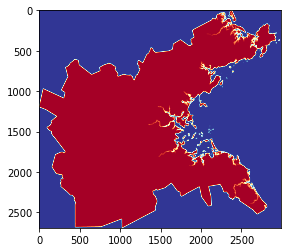

In [769]:
#plot the LST raster
show(lst_boston, cmap='RdYlBu_r')
plt.show()

In [770]:
#load the TCC raster and check for it's metadata, coordinate reference system and spatial resolution
with rasterio.open('./boston-data/RAW_DATA/Rasters/TreeCanopyCover/NLCD_2016_Tree_Canopy_Boston.tif') as tcc_mass:
    tcc_mass_meta = tcc_mass.meta
    tcc_mass_crs = tcc_mass.crs
    tcc_mass_r = tcc_mass.read(1)
    tcc_mass_res = tcc_mass.res
    tcc_mass_trf = tcc_mass.transform

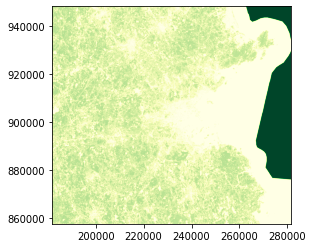

In [771]:
show(tcc_mass_r, transform=tcc_mass_trf, cmap='YlGn')
plt.show()

In [772]:
#check if the LST and TCC rasters have the same spatial resolution
tcc_mass_res == lst_res

True


#### Check the coordinate reference systems (CRS) for all rasters and vectors. Reproject vectors if they have a CRS different from the rasters.  

In [773]:
#check if the LST and TCC rasters have the same coordinate reference system
tcc_mass_crs == lst_crs

True

In [774]:
select_mpo.crs == lst_crs

False

In [775]:
ZCTA.crs == lst_crs

False

In [776]:
#reproject vector files using the CRS of the LST file (epsg: 6491)
boston_mpo = select_mpo.to_crs(lst_crs)
ZCTA_prj = ZCTA.to_crs(lst_crs)

In [777]:
boston_mpo.crs

<Projected CRS: EPSG:6491>
Name: NAD_1983_2011_StatePlane_Massachusetts_Mainland_FIPS_2001
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [778]:
ZCTA_prj.crs

<Projected CRS: EPSG:6491>
Name: NAD_1983_2011_StatePlane_Massachusetts_Mainland_FIPS_2001
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich


#### Clip the ZCTA boundaries to the Boston MPO boundary

In [779]:
ZCTA_boston = gpd.clip(ZCTA_prj, boston_mpo)

In [780]:
ZCTA_boston.head()

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25     01905  2501905        B5   G6350          S   9219345   
18        25     01904  2501904        B5   G6350          S  11708211   
20        25     01930  2501930        B5   G6350          S  67847425   
21        25     01915  2501915        B5   G6350          S  39091336   
22        25     01921  2501921        B5   G6350          S  61010486   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   
21   3958118  +42.5702688  -070.8669962         N   
22   2188501  +42.6831083  -071.0183302         N   

                                             geometry  
17  MULTIPOLYGON (((242015.723 912264.426, 242003....  
18  POLYGON ((245700.484 914778.700, 245667.412 91...  
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  
21  MULTIPOLYGON (((248320.748 922288.194, 248336....  
22  MULTIPOLYGON (((239176.448 932450.594, 242088....

In [781]:
ZCTA_boston.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 197 entries, 17 to 534
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   197 non-null    object  
 1   ZCTA5CE10   197 non-null    object  
 2   GEOID10     197 non-null    object  
 3   CLASSFP10   197 non-null    object  
 4   MTFCC10     197 non-null    object  
 5   FUNCSTAT10  197 non-null    object  
 6   ALAND10     197 non-null    int64   
 7   AWATER10    197 non-null    int64   
 8   INTPTLAT10  197 non-null    object  
 9   INTPTLON10  197 non-null    object  
 10  PARTFLG10   197 non-null    object  
 11  geometry    197 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 20.0+ KB


In [782]:
#convert the data type of the column 'ZCTA5CE10' from string to numberic
ZCTA_boston['ZCTA5CE10'] = pd.to_numeric(ZCTA_boston.ZCTA5CE10)
ZCTA_boston.dtypes

STATEFP10       object
ZCTA5CE10        int64
GEOID10         object
CLASSFP10       object
MTFCC10         object
FUNCSTAT10      object
ALAND10          int64
AWATER10         int64
INTPTLAT10      object
INTPTLON10      object
PARTFLG10       object
geometry      geometry
dtype: object

<AxesSubplot:>

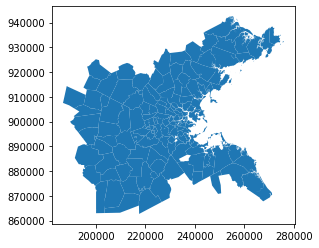

In [783]:
ZCTA_boston.plot()


#### Attribute join: Join the four demographic variables with the ZCTA_boston shapefile to create four different shapefiles, based on ZCTA codes

**Attribute Join: Percentage of people below poverty level**

In [784]:
poverty_jn = ZCTA_boston.merge(poverty, left_on='ZCTA5CE10', right_on='ID_CODE')

In [785]:
poverty_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME S1701_C03_001E  ID_CODE  
0  ZCTA5 01905           16.4     1905  
1  ZCTA5 01904            7.4     1904  
2  ZCTA5 01930             10     1930

In [786]:
poverty_jn['S1701_C03_001E'] = pd.to_numeric(poverty_jn.S1701_C03_001E)
poverty_jn.dtypes

STATEFP10           object
ZCTA5CE10            int64
GEOID10             object
CLASSFP10           object
MTFCC10             object
FUNCSTAT10          object
ALAND10              int64
AWATER10             int64
INTPTLAT10          object
INTPTLON10          object
PARTFLG10           object
geometry          geometry
GEO_ID              object
NAME                object
S1701_C03_001E     float64
ID_CODE              int64
dtype: object

In [787]:
#statistical summary of the column with percent values for population below poverty level
poverty_jn['S1701_C03_001E'].describe()

count    197.000000
mean       8.011675
std        8.359793
min        0.000000
25%        3.200000
50%        4.800000
75%        9.800000
max       69.400000
Name: S1701_C03_001E, dtype: float64

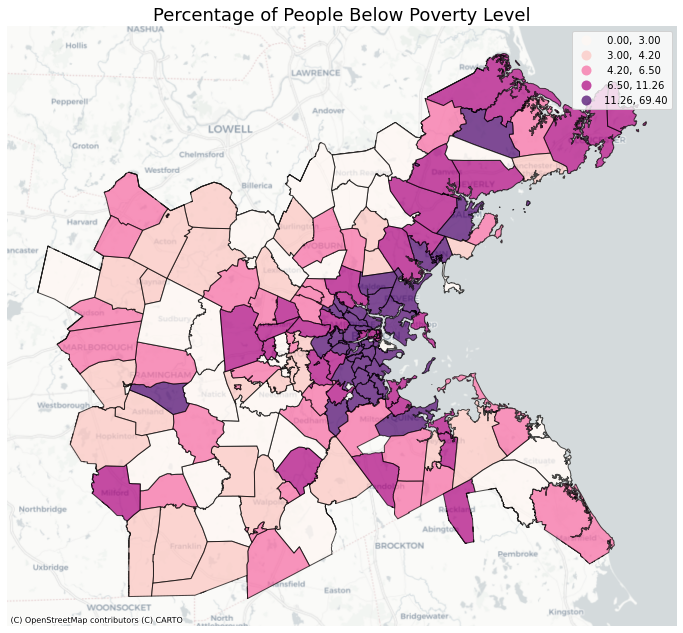

In [788]:
#plot the percentage of people below poverty level in every ZCTA
fig, ax = plt.subplots(1, figsize=(12,12))
poverty_jn.plot(ax=ax, column='S1701_C03_001E', scheme='Quantiles', k=5, edgecolor = 'black', categorical=False, legend=True, cmap='RdPu', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston.crs.to_string())
_ = ax.axis('off')
ax.set_title("Percentage of People Below Poverty Level", fontsize=18)
plt.show()


**Attribute Join: Age-dependency Ratio**

In [789]:
age_dep_ratio_jn = ZCTA_boston.merge(age_dep_ratio, left_on='ZCTA5CE10', right_on='ID_CODE')

In [790]:
age_dep_ratio_jn.dtypes

STATEFP10           object
ZCTA5CE10            int64
GEOID10             object
CLASSFP10           object
MTFCC10             object
FUNCSTAT10          object
ALAND10              int64
AWATER10             int64
INTPTLAT10          object
INTPTLON10          object
PARTFLG10           object
geometry          geometry
GEO_ID              object
NAME                object
S0101_C01_034E      object
ID_CODE              int64
dtype: object

In [791]:
age_dep_ratio_jn['S0101_C01_034E'] = pd.to_numeric(age_dep_ratio_jn.S0101_C01_034E, errors='coerce')
age_dep_ratio_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  S0101_C01_034E  ID_CODE  
0  ZCTA5 01905            55.9     1905  
1  ZCTA5 01904            56.5     1904  
2  ZCTA5 01930            65.5     1930

In [792]:
#statistical summary of the age-dependency ratio
age_dep_ratio_jn['S0101_C01_034E'].describe()

count    195.000000
mean      58.711795
std       19.180099
min        1.000000
25%       49.700000
50%       60.600000
75%       70.350000
max      125.600000
Name: S0101_C01_034E, dtype: float64

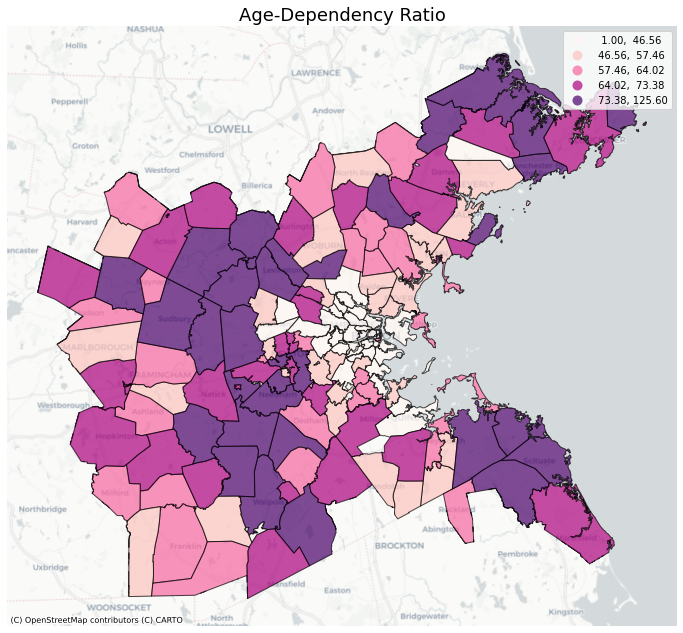

In [793]:
#plot the age-dependency ratio in every ZCTA
fig, ax = plt.subplots(1, figsize=(12,12))
age_dep_ratio_jn.plot(ax=ax, column='S0101_C01_034E', scheme='Quantiles', k=5, edgecolor = 'black', categorical=False, legend=True, cmap='RdPu', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston.crs.to_string())
_ = ax.axis('off')
ax.set_title("Age-Dependency Ratio", fontsize=18)
plt.show()


**Attribute Join: Population (over 25yrs) with less than a high school degree**

In [794]:
edu_attain_jn = ZCTA_boston.merge(edu_attain, left_on='ZCTA5CE10', right_on='ID_CODE')

In [795]:
edu_attain_jn.dtypes

STATEFP10           object
ZCTA5CE10            int64
GEOID10             object
CLASSFP10           object
MTFCC10             object
FUNCSTAT10          object
ALAND10              int64
AWATER10             int64
INTPTLAT10          object
INTPTLON10          object
PARTFLG10           object
geometry          geometry
GEO_ID              object
NAME                object
S1501_C01_006E       int64
S1501_C01_007E       int64
S1501_C01_008E       int64
ID_CODE              int64
dtype: object

*Calculate the percentage of people over 25 years with less than a high school degree. The calculation uses three columns from the edu_attain table: total population(S1501_C01_006E), people over 25 years with educational attainment below 9th grade(S1501_C01_007E) and 9th to 12th grade with no diploma(S1501_C01_008E).*

In [796]:
edu_attain_jn['EDU_ATTAIN'] = ((edu_attain_jn['S1501_C01_007E'] + edu_attain_jn['S1501_C01_008E'])/edu_attain_jn['S1501_C01_006E'])*100

In [797]:
edu_attain_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  S1501_C01_006E  S1501_C01_007E  S1501_C01_008E  ID_CODE  \
0  ZCTA5 01905           15796            2594            1174     1905   
1  ZCTA5 01904           11797             769             688     1904   
2  ZCTA5 01930           23175             836             912     1930   

   EDU_ATTAIN  
0   23.854140  
1   12.350598  
2    7.542611

In [798]:
#statistical summary of people over 25 years (percentage) with less than a High School degree
edu_attain_jn['EDU_ATTAIN'].describe()

count    197.000000
mean       6.106681
std        6.294851
min        0.000000
25%        2.447875
50%        4.103927
75%        7.305378
max       38.888889
Name: EDU_ATTAIN, dtype: float64

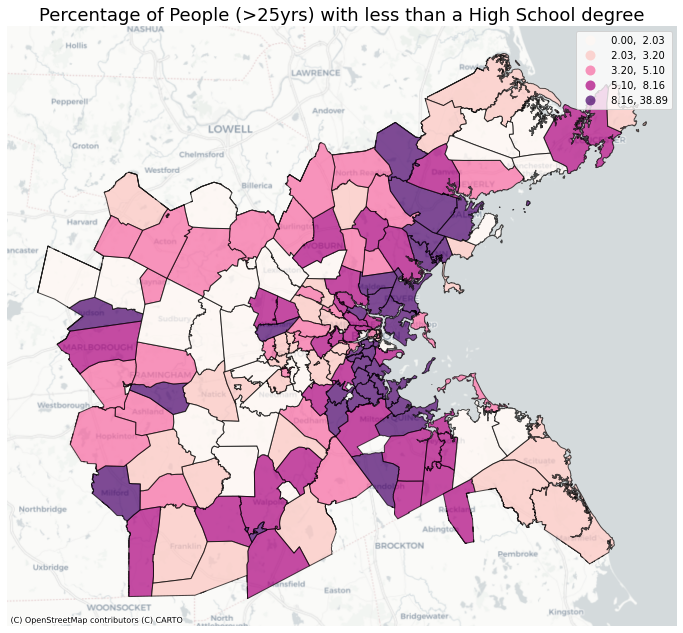

In [799]:
#plot the educational attainment in every ZCTA
fig, ax = plt.subplots(1, figsize=(12,12))
edu_attain_jn.plot(ax=ax, column='EDU_ATTAIN', scheme='Quantiles', k=5, edgecolor = 'black', categorical=False, legend=True, cmap='RdPu', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston.crs.to_string())
_ = ax.axis('off')
ax.set_title("Percentage of People (>25yrs) with less than a High School degree", fontsize=18)
plt.show()


**Attribute Join: Percentage of Non-Whites**

In [800]:
race_jn = ZCTA_boston.merge(race, left_on='ZCTA5CE10', right_on='ID_CODE')

In [801]:
race_jn.dtypes

STATEFP10        object
ZCTA5CE10         int64
GEOID10          object
CLASSFP10        object
MTFCC10          object
FUNCSTAT10       object
ALAND10           int64
AWATER10          int64
INTPTLAT10       object
INTPTLON10       object
PARTFLG10        object
geometry       geometry
GEO_ID           object
NAME             object
B02001_001E       int64
B02001_002E       int64
ID_CODE           int64
dtype: object

*Calculate the percentage of non-whites. The calculation uses three columns from the race table: total population(B02001_001E) and White population(B02001_002E).*

In [802]:
race_jn['NON_WHITE'] = ((race_jn['B02001_001E'] - race_jn['B02001_002E'])/race_jn['B02001_001E'])*100

In [803]:
race_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  B02001_001E  B02001_002E  ID_CODE  NON_WHITE  
0  ZCTA5 01905        24580        11203     1905  54.422295  
1  ZCTA5 01904        17294        13202     1904  23.661385  
2  ZCTA5 01930        30162        28236     1930   6.385518

In [804]:
#statistical summary of percentage of non-Whites
race_jn['NON_WHITE'].describe()

count    197.000000
mean      21.192665
std       17.368096
min        0.000000
25%        7.940790
50%       17.413890
75%       26.907732
max       93.241053
Name: NON_WHITE, dtype: float64

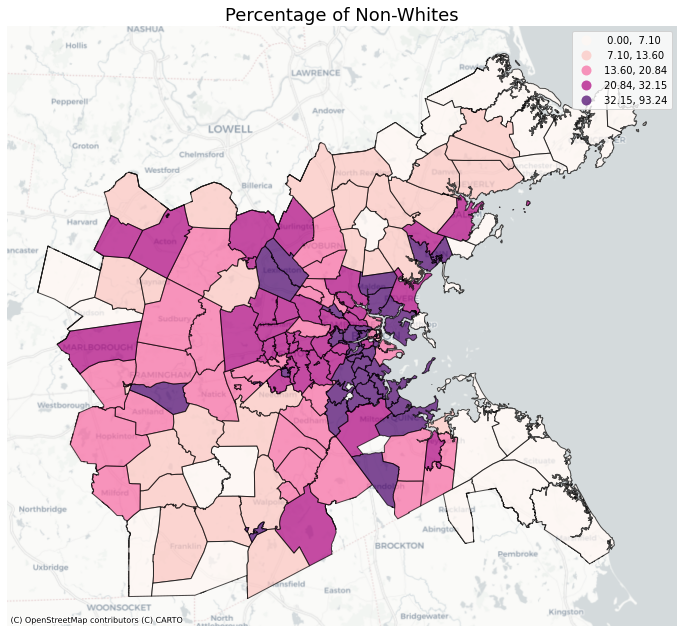

In [805]:
#plot the percentage of non-Whites in every ZCTA
fig, ax = plt.subplots(1, figsize=(12,12))
race_jn.plot(ax=ax, column='NON_WHITE', scheme='Quantiles', k=5, edgecolor = 'black', categorical=False, legend=True, cmap='RdPu', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston.crs.to_string())
_ = ax.axis('off')
ax.set_title("Percentage of Non-Whites", fontsize=18)
plt.show()


#### Zonal statistics on LST Raster

In [806]:
#calculate the mean LST for every ZCTA
lst_stats = pd.DataFrame(zonal_stats(ZCTA_boston, lst_boston, affine=lst_trf, stats=['mean'], nodata = np.NaN))
lst_stats.head(10)

mean
0 -2.464006e+36
1  2.577153e+01
2 -5.810509e+36
3 -1.363151e+36
4 -6.301525e+37
5  2.681719e+01
6  2.560164e+01
7  2.698344e+01
8  2.899443e+01
9  2.521144e+01

In [807]:
#join the mean LST info for every ZCTA with the boundary shapefile
ZCTA_boston_stat = ZCTA_boston.join(lst_stats)

In [808]:
ZCTA_boston_stat.head()

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   
21        25       1915  2501915        B5   G6350          S  39091336   
22        25       1921  2501921        B5   G6350          S  61010486   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   
21   3958118  +42.5702688  -070.8669962         N   
22   2188501  +42.6831083  -071.0183302         N   

                                             geometry          mean  
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36  
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37  
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01  
21  MULTIPOLYGON (((248320.748 922288.194, 248336.... -4.580724e+37  
22  MULTIPOLYGON (((239176.448 932450.594, 242088....  2.408090e+01

In [809]:
#rename the column that contains the mean LST values
ZCTA_boston_stat.rename(columns = {'mean': 'LST_mean'}, inplace = True)
ZCTA_boston_stat.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   

                                             geometry      LST_mean  
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36  
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37  
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01


#### Zonal statistics on TCC Raster

In [810]:
#calculate the mean TCC for every ZCTA
tcc_stats = pd.DataFrame(zonal_stats(ZCTA_boston, tcc_mass_r, affine=lst_trf, stats=['mean'], nodata = np.NaN))
tcc_stats.head(10)

mean
0  35.277269
1  48.915544
2  16.569493
3  51.584867
4  73.703704
5  78.404866
6  44.938294
7  58.865277
8  48.859913
9  59.205672

In [811]:
#join the mean TCC info for every ZCTA with the boundary shapefile
ZCTA_boston_stat = ZCTA_boston_stat.join(tcc_stats)

In [812]:
ZCTA_boston_stat.head()

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   
21        25       1915  2501915        B5   G6350          S  39091336   
22        25       1921  2501921        B5   G6350          S  61010486   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   
21   3958118  +42.5702688  -070.8669962         N   
22   2188501  +42.6831083  -071.0183302         N   

                                             geometry      LST_mean       mean  
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36   4.222703  
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37   7.907692  
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01  77.181818  
21  MULTIPOLYGON (((248320.748 922288.194, 248336.... -4.580724e+37  46.750000  
22  MULTIPOLYGON (((239176.448 932450.594, 242088....  2.408090e+01  54.421480

In [813]:
#rename the column that contains the mean TCC values
ZCTA_boston_stat.rename(columns = {'mean': 'TCC_mean'}, inplace = True)
ZCTA_boston_stat.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   

                                             geometry      LST_mean   TCC_mean  
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36   4.222703  
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37   7.907692  
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01  77.181818

In [814]:
#replace the cells with missing mean LST and TCC values by 0
ZCTA_boston_stat['TCC_mean'] = ZCTA_boston_stat['TCC_mean'].replace(np.NaN, 0)
ZCTA_boston_stat['LST_mean'] = ZCTA_boston_stat['LST_mean'].replace(np.NaN, 0)


#### Cateforize the demographic variables into categories
> Noramlize the column using mean and standard deviation and then create bins to classify the data

In [815]:
#create bins and groups to classify the demographic variables, mean LST and TCC values for every ZCTA.
# group 1 indicates less vulnerability and group 5 indicates high vulnerability
bins = [-np.inf, 0.2, 0.4, 0.6, 0.8, np.inf]
groups = [1, 2, 3, 4, 5]


**Percentage of people below poverty level**

In [816]:
#normalize the poverty variable using mean and standard deviation
#higher the normalized value, higher the vulnerability
poverty_jn["NORM_POV"] = (poverty_jn["S1701_C03_001E"] - poverty_jn["S1701_C03_001E"].mean())/poverty_jn["S1701_C03_001E"].std()
poverty_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  S1701_C03_001E  ID_CODE  NORM_POV  
0  ZCTA5 01905            16.4     1905  1.003413  
1  ZCTA5 01904             7.4     1904 -0.073169  
2  ZCTA5 01930            10.0     1930  0.237844

In [817]:
#create a new column that shows the vulnerability category based on poverty
poverty_jn["POV_CAT"] = pd.cut(poverty_jn["NORM_POV"], bins, labels=groups)

In [818]:
#convert the category column from dtype category to numeric
poverty_jn["POV_VUL"] = pd.to_numeric(poverty_jn.POV_CAT)
poverty_jn.dtypes

STATEFP10           object
ZCTA5CE10            int64
GEOID10             object
CLASSFP10           object
MTFCC10             object
FUNCSTAT10          object
ALAND10              int64
AWATER10             int64
INTPTLAT10          object
INTPTLON10          object
PARTFLG10           object
geometry          geometry
GEO_ID              object
NAME                object
S1701_C03_001E     float64
ID_CODE              int64
NORM_POV           float64
POV_CAT           category
POV_VUL              int64
dtype: object


**Age-dependency Ratio**

In [819]:
#normalize the age-dependency variable using mean and standard deviation
#higher the normalized value, higher the vulnerability
age_dep_ratio_jn["NORM_AGE"] = (age_dep_ratio_jn["S0101_C01_034E"] - age_dep_ratio_jn["S0101_C01_034E"].mean())/age_dep_ratio_jn["S0101_C01_034E"].std()
age_dep_ratio_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  S0101_C01_034E  ID_CODE  NORM_AGE  
0  ZCTA5 01905            55.9     1905 -0.146600  
1  ZCTA5 01904            56.5     1904 -0.115317  
2  ZCTA5 01930            65.5     1930  0.353919

In [820]:
#create a new column that shows the vulnerability category based on age-dependency
age_dep_ratio_jn["AGE_CAT"] = pd.cut(age_dep_ratio_jn["NORM_AGE"], bins, labels=groups)

In [821]:
#convert the category column from dtype category to numeric
age_dep_ratio_jn["AGE_VUL"] = pd.to_numeric(age_dep_ratio_jn.AGE_CAT)
age_dep_ratio_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  S0101_C01_034E  ID_CODE  NORM_AGE AGE_CAT  AGE_VUL  
0  ZCTA5 01905            55.9     1905 -0.146600       1      1.0  
1  ZCTA5 01904            56.5     1904 -0.115317       1      1.0  
2  ZCTA5 01930            65.5     1930  0.353919       2      2.0


**Population (over 25yrs) with less than a high school degree**

In [822]:
#normalize the educational attainment variable using mean and standard deviation
#higher the normalized value, higher the vulnerability
edu_attain_jn["NORM_EDU"] = (edu_attain_jn["EDU_ATTAIN"] - edu_attain_jn["EDU_ATTAIN"].mean())/edu_attain_jn["EDU_ATTAIN"].std()
edu_attain_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  S1501_C01_006E  S1501_C01_007E  S1501_C01_008E  ID_CODE  \
0  ZCTA5 01905           15796            2594            1174     1905   
1  ZCTA5 01904           11797             769             688     1904   
2  ZCTA5 01930           23175             836             912     1930   

   EDU_ATTAIN  NORM_EDU  
0   23.854140  2.819361  
1   12.350598  0.991909  
2    7.542611  0.228112

In [823]:
#create a new column that shows the vulnerability category based on educational attainment
edu_attain_jn["EDU_CAT"] = pd.cut(edu_attain_jn["NORM_EDU"], bins, labels=groups)

In [824]:
#convert the category column from dtype category to numeric
edu_attain_jn["EDU_VUL"] = pd.to_numeric(edu_attain_jn.EDU_CAT)
edu_attain_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10  ...          GEO_ID         NAME  \
0   1195154  +42.4659985  -070.9757922  ...  8600000US01905  ZCTA5 01905   
1   1303900  +42.4924563  -070.9739297  ...  8600000US01904  ZCTA5 01904   
2  13972397  +42.6199100  -070.6818235  ...  8600000US01930  ZCTA5 01930   

  S1501_C01_006E S1501_C01_007E  S1501_C01_008E  ID_CODE  EDU_ATTAIN  \
0          15796           2594            1174     1905   23.854140   
1          11797            769             688     1904   12.350598   
2          23175            836             912     1930    7.542611   

   NORM_EDU  EDU_CAT  EDU_VUL  
0  2.819361        5        5  
1  0.991909        5        5  
2  0.228112        2        2  

[3 rows x 22 columns]


**Percentage of Non-Whites**

In [825]:
#normalize the race variable using mean and standard deviation
#higher the normalized value, higher the vulnerability
race_jn["NORM_RCE"] = (race_jn["NON_WHITE"] - race_jn["NON_WHITE"].mean())/race_jn["NON_WHITE"].std()
race_jn.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0        25       1905  2501905        B5   G6350          S   9219345   
1        25       1904  2501904        B5   G6350          S  11708211   
2        25       1930  2501930        B5   G6350          S  67847425   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0   1195154  +42.4659985  -070.9757922         N   
1   1303900  +42.4924563  -070.9739297         N   
2  13972397  +42.6199100  -070.6818235         N   

                                            geometry          GEO_ID  \
0  MULTIPOLYGON (((242015.723 912264.426, 242003....  8600000US01905   
1  POLYGON ((245700.484 914778.700, 245667.412 91...  8600000US01904   
2  MULTIPOLYGON (((264432.624 925340.672, 264423....  8600000US01930   

          NAME  B02001_001E  B02001_002E  ID_CODE  NON_WHITE  NORM_RCE  
0  ZCTA5 01905        24580        11203     1905  54.422295  1.913257  
1  ZCTA5 01904        17294        13202     1904  23.661385  0.142141  
2  ZCTA5 01930        30162        28236     1930   6.385518 -0.852549

In [826]:
#create a new column that shows the vulnerability category based on race
race_jn["RCE_CAT"] = pd.cut(race_jn["NORM_RCE"], bins, labels=groups)

In [827]:
#convert the category column from dtype category to numeric
race_jn["RCE_VUL"] = pd.to_numeric(race_jn.RCE_CAT)

####
**LST and TCC Boston (Zonal Stat output)**

In [828]:
#normalize the mean LST and TCC variables using mean and standard deviation
#higher the normalized value, higher the vulnerability for LST
#higher the normalized value, lesser the vulnerability for TCC
ZCTA_boston_stat["LST_NORM"] = (ZCTA_boston_stat["LST_mean"] - ZCTA_boston_stat["LST_mean"].mean())/ZCTA_boston_stat["LST_mean"].std()
ZCTA_boston_stat["TCC_NORM"] = (ZCTA_boston_stat["TCC_mean"] - ZCTA_boston_stat["TCC_mean"].mean())/ZCTA_boston_stat["TCC_mean"].std()
ZCTA_boston_stat.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   

                                             geometry      LST_mean  \
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36   
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37   
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01   

     TCC_mean  LST_NORM  TCC_NORM  
17   4.222703 -0.209863 -0.458085  
18   7.907692 -0.411436 -0.304229  
20  77.181818  0.140161  2.588119

In [829]:
#create a new column that shows the vulnerability category based on mean LST
ZCTA_boston_stat["LST_CAT"] = pd.cut(ZCTA_boston_stat["LST_NORM"], bins, labels=groups)
ZCTA_boston_stat["LST_CAT"] = pd.to_numeric(ZCTA_boston_stat.LST_CAT)
ZCTA_boston_stat.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   

                                             geometry      LST_mean  \
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36   
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37   
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01   

     TCC_mean  LST_NORM  TCC_NORM  LST_CAT  
17   4.222703 -0.209863 -0.458085        1  
18   7.907692 -0.411436 -0.304229        1  
20  77.181818  0.140161  2.588119        1

In [830]:
#create new groups for mean TCC as higher normalized values indicate lesser vulnerability
#create a new column that shows the vulnerability category based on mean TCC
groups_tcc = [5, 4, 3, 2, 1]
ZCTA_boston_stat["TCC_CAT"] = pd.cut(ZCTA_boston_stat["TCC_NORM"], bins, labels=groups_tcc)
ZCTA_boston_stat["TCC_CAT"] = pd.to_numeric(ZCTA_boston_stat.TCC_CAT)
ZCTA_boston_stat.head(3)

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
17        25       1905  2501905        B5   G6350          S   9219345   
18        25       1904  2501904        B5   G6350          S  11708211   
20        25       1930  2501930        B5   G6350          S  67847425   

    AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
17   1195154  +42.4659985  -070.9757922         N   
18   1303900  +42.4924563  -070.9739297         N   
20  13972397  +42.6199100  -070.6818235         N   

                                             geometry      LST_mean  \
17  MULTIPOLYGON (((242015.723 912264.426, 242003.... -7.474536e+36   
18  POLYGON ((245700.484 914778.700, 245667.412 91... -1.177900e+37   
20  MULTIPOLYGON (((264432.624 925340.672, 264423....  2.464355e+01   

     TCC_mean  LST_NORM  TCC_NORM  LST_CAT  TCC_CAT  
17   4.222703 -0.209863 -0.458085        1        5  
18   7.907692 -0.411436 -0.304229        1        5  
20  77.181818  0.140161  2.588119        1        1

####
####
#### Attribute join all the demographic variables based on ZCTA codes

In [831]:
ZCTA_boston_stat2 = ZCTA_boston_stat.merge(race_jn, how='left', on='ZCTA5CE10')

In [832]:
ZCTA_boston_stat3 = ZCTA_boston_stat2.merge(edu_attain_jn, how='left', on='ZCTA5CE10')

In [833]:
ZCTA_boston_stat4 = ZCTA_boston_stat3.merge(age_dep_ratio_jn, how='left', on='ZCTA5CE10')

In [834]:
ZCTA_boston_stat5 = ZCTA_boston_stat4.merge(poverty_jn, how='left', on='ZCTA5CE10')

In [835]:
ZCTA_boston_stat5_copy = ZCTA_boston_stat5.copy()

In [836]:
#drop the columns that are not needed
ZCTA_boston_stat5_copy2 = ZCTA_boston_stat5_copy.drop(columns=['STATEFP10_x','GEOID10_x','CLASSFP10_x','MTFCC10_x','FUNCSTAT10_x',
                                                               'ALAND10_x','AWATER10_x','INTPTLAT10_x','INTPTLON10_x','PARTFLG10_x','geometry_x',
                                                               'LST_NORM','TCC_NORM','STATEFP10_y','GEOID10_y','CLASSFP10_y','MTFCC10_y',
                                                               'FUNCSTAT10_y','ALAND10_y','AWATER10_y','INTPTLAT10_y','INTPTLON10_y',
                                                               'PARTFLG10_y','geometry_y','GEO_ID_x','NAME_x','B02001_001E','B02001_002E',
                                                               'ID_CODE_x','NORM_RCE','RCE_CAT','STATEFP10_x','GEOID10_x','CLASSFP10_x','MTFCC10_x','FUNCSTAT10_x',
                                                               'ALAND10_x','AWATER10_x','INTPTLAT10_x','INTPTLON10_x','PARTFLG10_x',
                                                               'geometry_x','GEO_ID_y','NAME_y','S1501_C01_006E','S1501_C01_007E',
                                                               'S1501_C01_008E','ID_CODE_y','NORM_EDU','EDU_CAT',
                                                               'STATEFP10_y','GEOID10_y','CLASSFP10_y','MTFCC10_y','FUNCSTAT10_y','ALAND10_y',
                                                               'AWATER10_y','INTPTLAT10_y','INTPTLON10_y','PARTFLG10_y','geometry_y','GEO_ID_x',
                                                               'NAME_x','NORM_AGE','AGE_CAT','STATEFP10',
                                                               'GEOID10','CLASSFP10','MTFCC10','FUNCSTAT10','ALAND10','AWATER10','INTPTLAT10',
                                                               'INTPTLON10','PARTFLG10','geometry','GEO_ID_y','NAME_y',
                                                               'NORM_POV','POV_CAT'])
ZCTA_boston_stat5_copy2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 0 to 196
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ZCTA5CE10       197 non-null    int64  
 1   LST_mean        197 non-null    float64
 2   TCC_mean        197 non-null    float64
 3   LST_CAT         197 non-null    int64  
 4   TCC_CAT         197 non-null    int64  
 5   NON_WHITE       197 non-null    float64
 6   RCE_VUL         197 non-null    int64  
 7   EDU_ATTAIN      197 non-null    float64
 8   EDU_VUL         197 non-null    int64  
 9   S0101_C01_034E  195 non-null    float64
 10  AGE_VUL         195 non-null    float64
 11  S1701_C03_001E  197 non-null    float64
 12  POV_VUL         197 non-null    int64  
dtypes: float64(7), int64(6)
memory usage: 21.5 KB



#### Join the cleaned table with all demographic, LST and TCC values with the ZCTA shapefile to create the final geodataframe for the analysis

In [837]:
ZCTA_boston_analysis = ZCTA_boston.merge(ZCTA_boston_stat5_copy2, left_on='ZCTA5CE10', right_on='ZCTA5CE10')
ZCTA_boston_analysis.rename(columns = {'S0101_C01_034E': 'AGE_DEP_R', 'S1701_C03_001E': 'POVERTY'}, inplace = True)


#### Visualization of all indicators used for the analysis

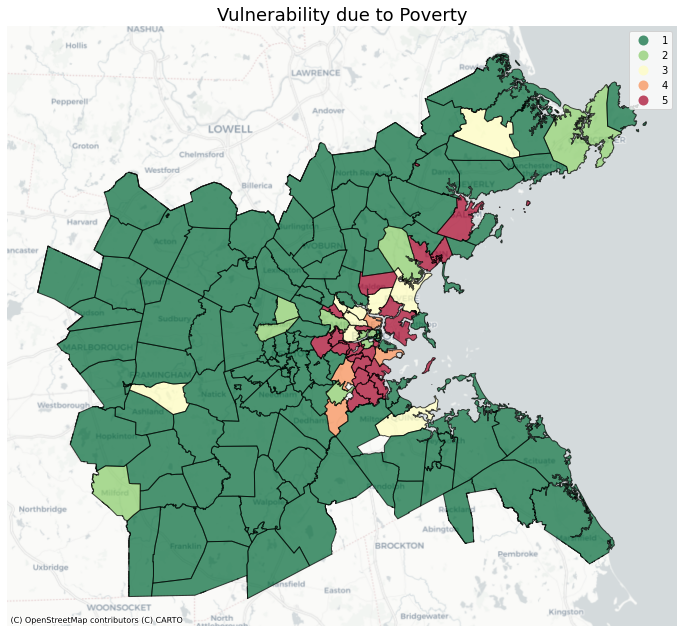

In [838]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='POV_VUL', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Vulnerability due to Poverty", fontsize=18)
plt.show()

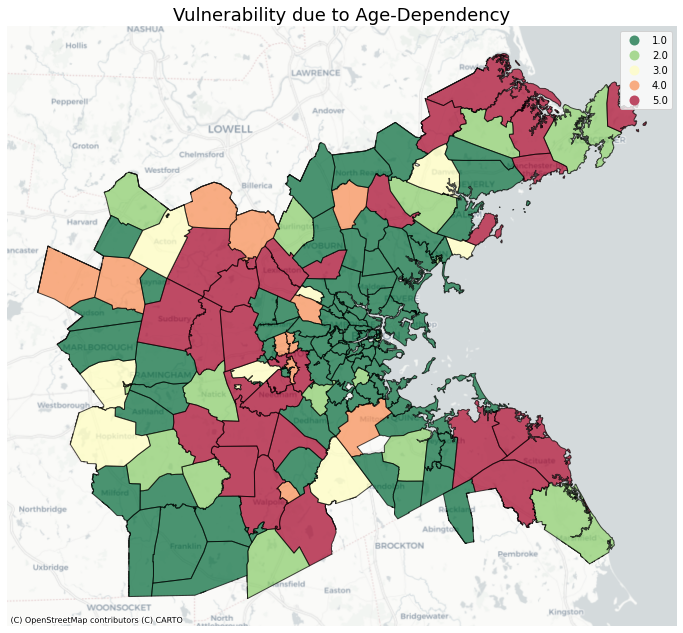

In [839]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='AGE_VUL', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Vulnerability due to Age-Dependency", fontsize=18)
plt.show()

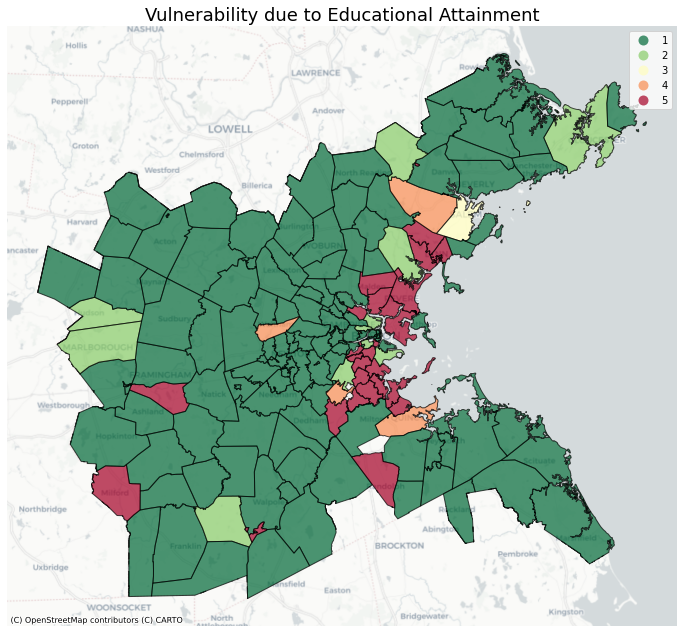

In [840]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='EDU_VUL', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Vulnerability due to Educational Attainment", fontsize=18)
plt.show()

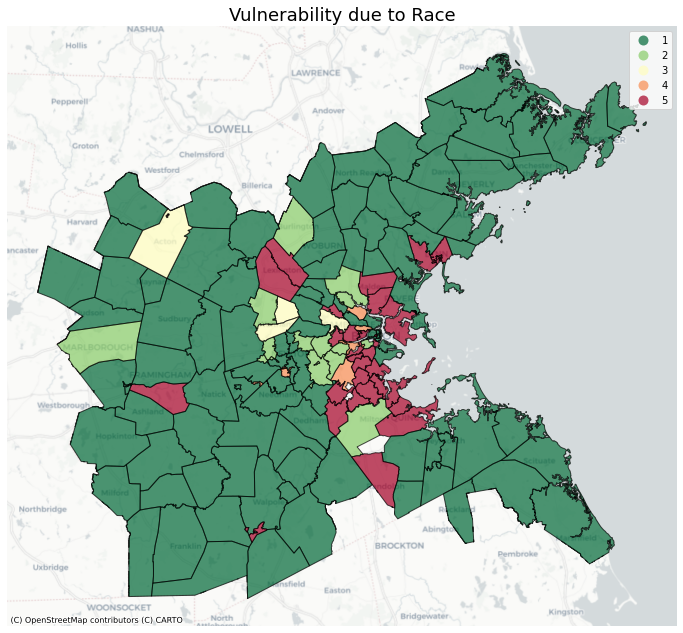

In [841]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='RCE_VUL', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Vulnerability due to Race", fontsize=18)
plt.show()

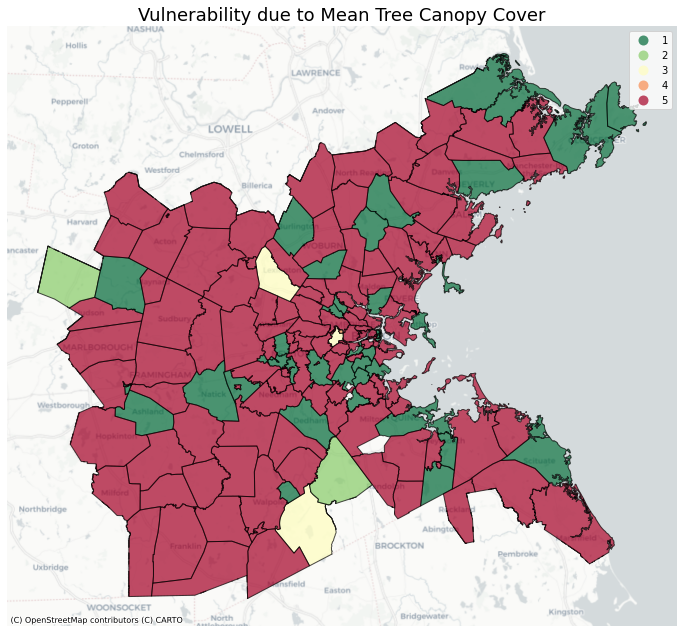

In [842]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='TCC_CAT', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Vulnerability due to Mean Tree Canopy Cover", fontsize=18)
plt.show()

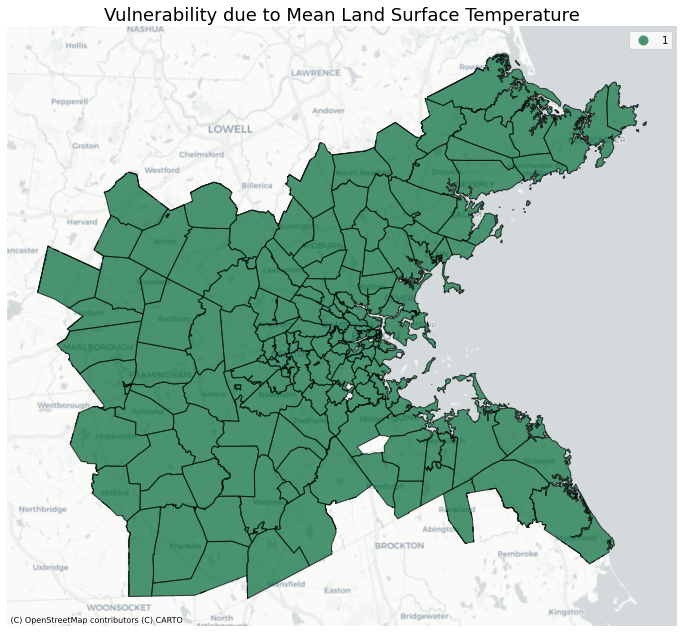

In [843]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='LST_CAT', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Vulnerability due to Mean Land Surface Temperature", fontsize=18)
plt.show()


#### Calculate vulnerability for every ZCTA and percentile rank them

> Create a new column called 'VUL_SUM' which is a sum of all vulnerability values (1=less vulnerable to 5=highly vulnerable) of all six variables used in the analysis: poverty, age-dependency ratio, educational attainment, race, mean LST and mean TCC. The highest aggregate score can be 30 and the lowest can be 6. 30 indicates high vulnerability and 6 indicates low vulnerability.

> High vulnerability ZCTAs have higher rank. Percentile rank is stored in the 'VUL_SCORE' column and calculated based on the column 'VUL_SUM'.

In [844]:
ZCTA_boston_analysis["VUL_SUM"] = ZCTA_boston_analysis["LST_CAT"] + ZCTA_boston_analysis["TCC_CAT"] + ZCTA_boston_analysis["POV_VUL"] + ZCTA_boston_analysis["AGE_VUL"] + ZCTA_boston_analysis["EDU_VUL"] + ZCTA_boston_analysis["RCE_VUL"]
ZCTA_boston_analysis["VUL_SCORE"] = ZCTA_boston_analysis.VUL_SUM.rank(pct=True)

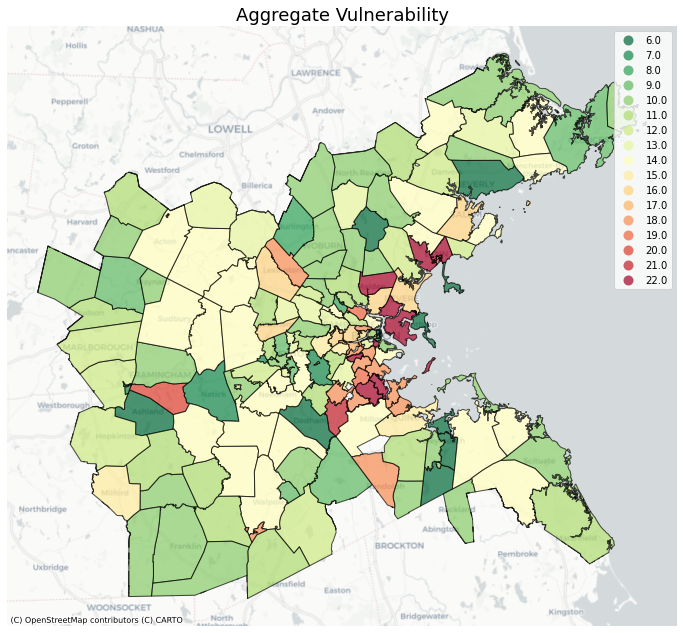

In [845]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_boston_analysis.plot(ax=ax, column='VUL_SUM', edgecolor = 'black', categorical=True, legend=True, cmap='RdYlGn_r', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Aggregate Vulnerability", fontsize=18)
plt.show()

#### Report Highest and Lowest ranking ZCTAs

In [846]:
ZCTA_mostVulnerable = ZCTA_boston_analysis[ZCTA_boston_analysis.VUL_SCORE>=0.8]
ZCTA_mostVulnerable['ZCTA5CE10'].count()

41

In [847]:
ZCTA_mostVulnerable.describe()

ZCTA5CE10       ALAND10      AWATER10      LST_mean   TCC_mean  \
count    41.000000  4.100000e+01  4.100000e+01  4.100000e+01  41.000000   
mean   2132.512195  8.570444e+06  1.052673e+06 -2.562216e+36  13.207875   
std     154.679042  8.604519e+06  2.391449e+06  1.254327e+37  21.086453   
min    1702.000000  1.489510e+05  0.000000e+00 -8.006643e+37   0.000000   
25%    2119.000000  2.850698e+06  5.693300e+04  0.000000e+00   0.000000   
50%    2135.000000  5.523791e+06  2.356380e+05  0.000000e+00   0.000000   
75%    2163.000000  1.188734e+07  7.362130e+05  0.000000e+00  25.300941   
max    2453.000000  3.853816e+07  1.419846e+07  3.149777e+01  61.336140   

       LST_CAT   TCC_CAT  NON_WHITE    RCE_VUL  EDU_ATTAIN    EDU_VUL  \
count     41.0  41.00000  41.000000  41.000000   41.000000  41.000000   
mean       1.0   4.00000  46.372710   4.414634   13.564640   3.829268   
std        0.0   1.67332  17.908725   1.224247    8.115774   1.730642   
min        1.0   1.00000  18.737666   1.000000    0.000000   1.000000   
25%        1.0   3.00000  35.090140   5.000000    8.051681   2.000000   
50%        1.0   5.00000  42.159854   5.000000   14.121558   5.000000   
75%        1.0   5.00000  57.492757   5.000000   18.213505   5.000000   
max        1.0   5.00000  93.241053   5.000000   31.045914   5.000000   

       AGE_DEP_R    AGE_VUL    POVERTY    POV_VUL    VUL_SUM  VUL_SCORE  
count  41.000000  41.000000  41.000000  41.000000  41.000000  41.000000  
mean   42.970732   1.243902  17.770732   3.804878  18.292683   0.897436  
std    19.369657   0.888270   8.909047   1.568750   2.410849   0.060106  
min     2.300000   1.000000   3.000000   1.000000  15.000000   0.805128  
25%    31.700000   1.000000  11.400000   3.000000  16.000000   0.835897  
50%    46.400000   1.000000  16.000000   5.000000  18.000000   0.900000  
75%    54.900000   1.000000  21.900000   5.000000  20.000000   0.948718  
max    88.800000   5.000000  39.400000   5.000000  22.000000   0.979487

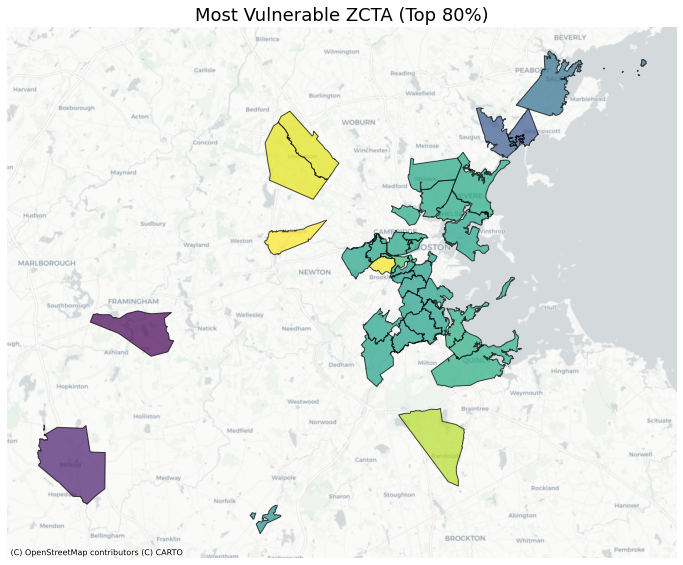

In [848]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_mostVulnerable.plot(ax=ax, column='ZCTA5CE10', edgecolor = 'black', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Most Vulnerable ZCTA (Top 80%)", fontsize=18)
plt.show()

In [849]:
ZCTA_leastVulnerable = ZCTA_boston_analysis[ZCTA_boston_analysis.VUL_SCORE<=0.2]
ZCTA_leastVulnerable['ZCTA5CE10'].count()

32

In [850]:
ZCTA_leastVulnerable.describe()

ZCTA5CE10       ALAND10      AWATER10      LST_mean   TCC_mean  \
count    32.000000  3.200000e+01  3.200000e+01  3.200000e+01  32.000000   
mean   2048.000000  2.580231e+07  1.796674e+06 -1.044689e+37  52.820121   
std     261.073837  2.320788e+07  2.574413e+06  4.988963e+37  11.962458   
min    1532.000000  2.608290e+05  0.000000e+00 -2.802325e+38  31.453318   
25%    1862.500000  4.773074e+06  2.146780e+05 -2.627541e+34  44.450800   
50%    2052.000000  2.172188e+07  1.206233e+06  2.372024e+01  49.784860   
75%    2190.250000  4.247010e+07  2.321730e+06  2.582028e+01  60.040946   
max    2467.000000  7.989751e+07  1.397240e+07  3.469788e+01  85.000000   

       LST_CAT    TCC_CAT  NON_WHITE    RCE_VUL  EDU_ATTAIN    EDU_VUL  \
count     32.0  32.000000  32.000000  32.000000   32.000000  32.000000   
mean       1.0   1.031250  14.491194   1.187500    3.991169   1.093750   
std        0.0   0.176777   7.739022   0.470929    2.023225   0.390151   
min        1.0   1.000000   4.111936   1.000000    0.000000   1.000000   
25%        1.0   1.000000   7.574539   1.000000    2.472646   1.000000   
50%        1.0   1.000000  14.816536   1.000000    3.823557   1.000000   
75%        1.0   1.000000  19.531474   1.000000    5.359793   1.000000   
max        1.0   2.000000  30.146557   3.000000    8.915099   3.000000   

       AGE_DEP_R   AGE_VUL    POVERTY    POV_VUL    VUL_SUM  VUL_SCORE  
count   32.00000  32.00000  32.000000  32.000000  32.000000  32.000000  
mean    58.86250   1.75000   5.296875   1.125000   7.187500   0.084615  
std     13.26338   1.04727   3.035222   0.421212   1.229673   0.045683  
min     15.90000   1.00000   0.000000   1.000000   6.000000   0.035897  
25%     57.40000   1.00000   3.300000   1.000000   6.000000   0.035897  
50%     61.85000   1.00000   4.100000   1.000000   7.000000   0.089744  
75%     65.62500   2.00000   8.025000   1.000000   8.250000   0.125000  
max     73.70000   4.00000  11.400000   3.000000   9.000000   0.146154

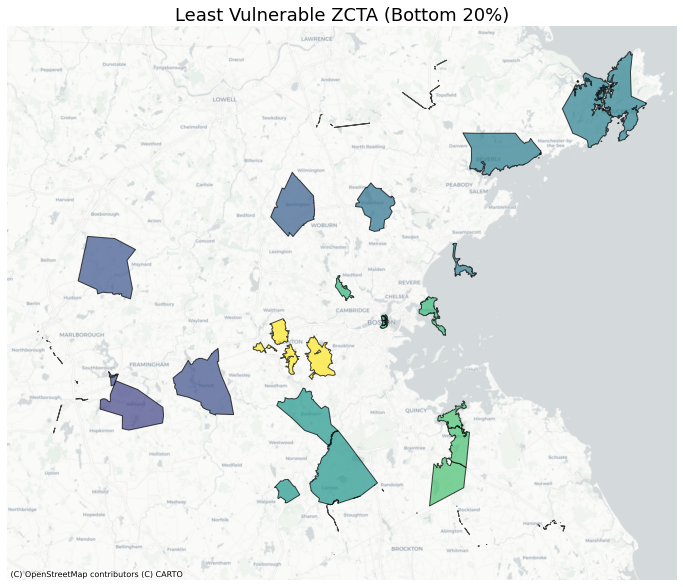

In [851]:
fig, ax = plt.subplots(1, figsize=(12,12))
ZCTA_leastVulnerable.plot(ax=ax, column='ZCTA5CE10', edgecolor = 'black', alpha=0.7)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=ZCTA_boston_analysis.crs.to_string())
_ = ax.axis('off')
ax.set_title("Least Vulnerable ZCTA (Bottom 20%)", fontsize=18)
plt.show()